# K-means Clustering

In [12]:
import matplotlib.pyplot as plt

# Though the following import is not directly being used, it is required
# for 3D projection to work with matplotlib < 3.2
import mpl_toolkits.mplot3d  # noqa: F401
import numpy as np

from sklearn import datasets
from sklearn.cluster import KMeans

np.random.seed(5)

iris = datasets.load_iris()
X = iris.data
y = iris.target

estimators = [
    ("k_means_iris_8", KMeans(n_clusters=8)),
    ("k_means_iris_3", KMeans(n_clusters=3)),
    ("k_means_iris_bad_init", KMeans(n_clusters=3, n_init=1, init="random")),
]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


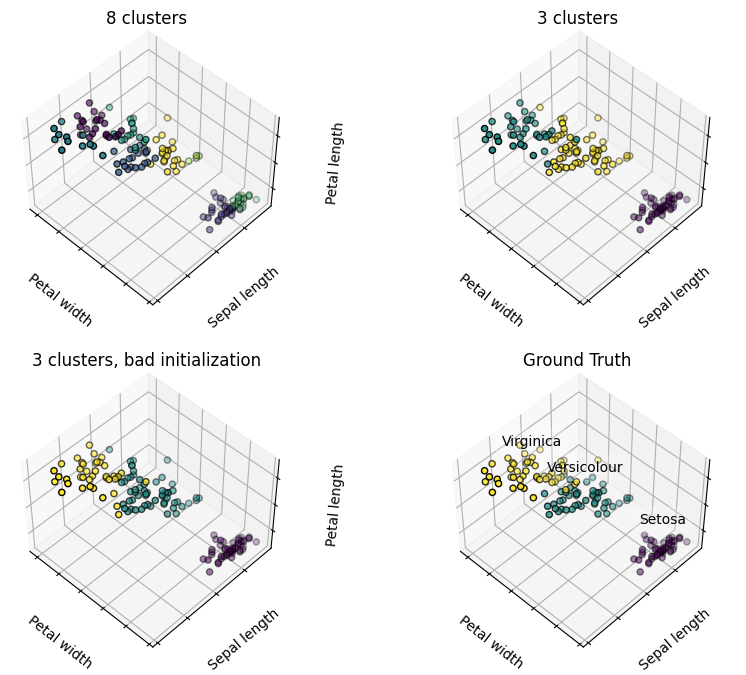

In [13]:
fig = plt.figure(figsize=(10, 8))
titles = ["8 clusters", "3 clusters", "3 clusters, bad initialization"]
for idx, ((name, est), title) in enumerate(zip(estimators, titles)):
    ax = fig.add_subplot(2, 2, idx + 1, projection="3d", elev=48, azim=134)
    est.fit(X)
    labels = est.labels_

    ax.scatter(X[:, 3], X[:, 0], X[:, 2], c=labels.astype(float), edgecolor="k")

    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.zaxis.set_ticklabels([])
    ax.set_xlabel("Petal width")
    ax.set_ylabel("Sepal length")
    ax.set_zlabel("Petal length")
    ax.set_title(title)

# Plot the ground truth
ax = fig.add_subplot(2, 2, 4, projection="3d", elev=48, azim=134)

for name, label in [("Setosa", 0), ("Versicolour", 1), ("Virginica", 2)]:
    ax.text3D(
        X[y == label, 3].mean(),
        X[y == label, 0].mean(),
        X[y == label, 2].mean() + 2,
        name,
        horizontalalignment="center",
        bbox=dict(alpha=0.2, edgecolor="w", facecolor="w"),
    )

ax.scatter(X[:, 3], X[:, 0], X[:, 2], c=y, edgecolor="k")

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])
ax.set_xlabel("Petal width")
ax.set_ylabel("Sepal length")
ax.set_zlabel("Petal length")
ax.set_title("Ground Truth")

plt.subplots_adjust(wspace=0.25, hspace=0.25)
plt.show()

The plot shows:

- top left: What a K-means algorithm would yield using 8 clusters.
- top right: What using three clusters would deliver.
- bottom left: What the effect of a bad initialization is on the classification process: By setting n_init to only 1 (default is 10), the amount of times that the algorithm will be run with different centroid seeds is reduced.
- bottom right: The ground truth.

# An example of K-Means++ initialization

An example to show the output of the sklearn.cluster.kmeans_plusplus function for generating initial seeds for clustering.

K-Means++ is used as the default initialization for K-means.

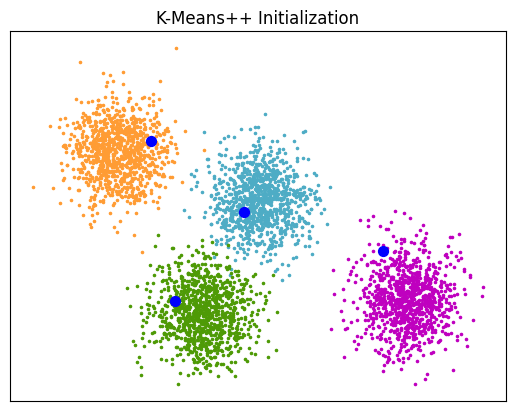

In [16]:
import matplotlib.pyplot as plt

from sklearn.cluster import kmeans_plusplus
from sklearn.datasets import make_blobs

# Generate sample data
n_samples = 4000
n_components = 4

X, y_true = make_blobs(
    n_samples=n_samples, centers=n_components, cluster_std=0.60, random_state=0
)
X = X[:, ::-1]

# Calculate seeds from k-means++
centers_init, indices = kmeans_plusplus(X, n_clusters=4, random_state=0)

# Plot init seeds along side sample data
plt.figure(1)
colors = ["#4EACC5", "#FF9C34", "#4E9A06", "m"]

for k, col in enumerate(colors):
    cluster_data = y_true == k
    plt.scatter(X[cluster_data, 0], X[cluster_data, 1], c=col, marker=".", s=10)

plt.scatter(centers_init[:, 0], centers_init[:, 1], c="b", s=50)
plt.title("K-Means++ Initialization")
plt.xticks([])
plt.yticks([])
plt.show()

# A demo of K-Means clustering on the handwritten digits data

In this example we compare the various initialization strategies for K-means in terms of runtime and quality of the results.

As the ground truth is known here, we also apply different cluster quality metrics to judge the goodness of fit of the cluster labels to the ground truth.

Cluster quality metrics evaluated (see Clustering performance evaluation for definitions and discussions of the metrics):

- homogeneity score
- completeness score
- V measure
- adjusted Rand index
- adjusted mutual information
- silhouette coefficient

In [1]:
import numpy as np

from sklearn.datasets import load_digits

data, labels = load_digits(return_X_y=True)
(n_samples, n_features), n_digits = data.shape, np.unique(labels).size

print(f"# digits: {n_digits}; # samples: {n_samples}; # features {n_features}")

# digits: 10; # samples: 1797; # features 64


Define our evaluation benchmark

We will first our evaluation benchmark. During this benchmark, we intend to compare different initialization methods for KMeans. Our benchmark will:

- create a pipeline which will scale the data using a StandardScaler;
- train and time the pipeline fitting;
- measure the performance of the clustering obtained via different metrics.

In [2]:
from time import time

from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=300,
        )
    ]

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

Run the benchmark#

We will compare three approaches:

- an initialization using k-means++. This method is stochastic and we will run the initialization 4 times;
- a random initialization. This method is stochastic as well and we will run the initialization 4 times;
- an initialization based on a PCA projection. Indeed, we will use the components of the PCA to initialize KMeans. This method is deterministic and a single initialization suffice.

In [3]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")

kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=data, labels=labels)

kmeans = KMeans(init="random", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=data, labels=labels)

pca = PCA(n_components=n_digits).fit(data)
kmeans = KMeans(init=pca.components_, n_clusters=n_digits, n_init=1)
bench_k_means(kmeans=kmeans, name="PCA-based", data=data, labels=labels)

print(82 * "_")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.505s	69545	0.598	0.645	0.621	0.469	0.617	0.157
random   	0.350s	69735	0.681	0.723	0.701	0.574	0.698	0.175
PCA-based	0.105s	72686	0.636	0.658	0.647	0.521	0.643	0.140
__________________________________________________________________________________


Visualize the results on PCA-reduced data

PCA allows to project the data from the original 64-dimensional space into a lower dimensional space. Subsequently, we can use PCA to project into a 2-dimensional space and plot the data and the clusters in this new space.

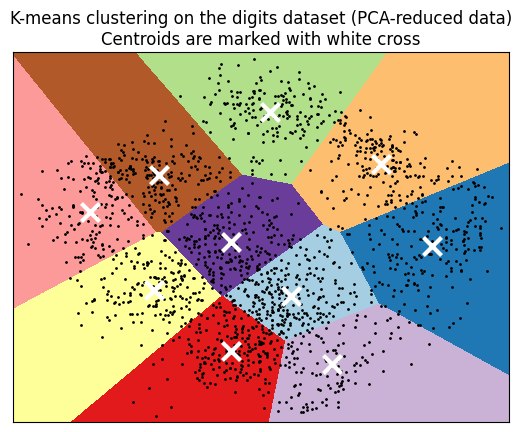

In [4]:
import matplotlib.pyplot as plt

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

# Color Quantization using K-Means

Performs a pixel-wise Vector Quantization (VQ) of an image of the summer palace (China), reducing the number of colors required to show the image from 96,615 unique colors to 64, while preserving the overall appearance quality.

In this example, pixels are represented in a 3D-space and K-means is used to find 64 color clusters. In the image processing literature, the codebook obtained from K-means (the cluster centers) is called the color palette. Using a single byte, up to 256 colors can be addressed, whereas an RGB encoding requires 3 bytes per pixel. The GIF file format, for example, uses such a palette.

For comparison, a quantized image using a random codebook (colors picked up randomly) is also shown.

In [5]:
from time import time

import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.datasets import load_sample_image
from sklearn.metrics import pairwise_distances_argmin
from sklearn.utils import shuffle

n_colors = 64

# Load the Summer Palace photo
china = load_sample_image("china.jpg")

# Convert to floats instead of the default 8 bits integer coding. Dividing by
# 255 is important so that plt.imshow works well on float data (need to
# be in the range [0-1])
china = np.array(china, dtype=np.float64) / 255

# Load Image and transform to a 2D numpy array.
w, h, d = original_shape = tuple(china.shape)
assert d == 3
image_array = np.reshape(china, (w * h, d))

print("Fitting model on a small sub-sample of the data")
t0 = time()
image_array_sample = shuffle(image_array, random_state=0, n_samples=1_000)
kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)
print(f"done in {time() - t0:0.3f}s.")

Fitting model on a small sub-sample of the data


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


done in 0.846s.


In [6]:
# Get labels for all points
print("Predicting color indices on the full image (k-means)")
t0 = time()
labels = kmeans.predict(image_array)
print(f"done in {time() - t0:0.3f}s.")


codebook_random = shuffle(image_array, random_state=0, n_samples=n_colors)
print("Predicting color indices on the full image (random)")
t0 = time()
labels_random = pairwise_distances_argmin(codebook_random, image_array, axis=0)
print(f"done in {time() - t0:0.3f}s.")


def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    return codebook[labels].reshape(w, h, -1)

Predicting color indices on the full image (k-means)
done in 0.068s.
Predicting color indices on the full image (random)
done in 0.144s.


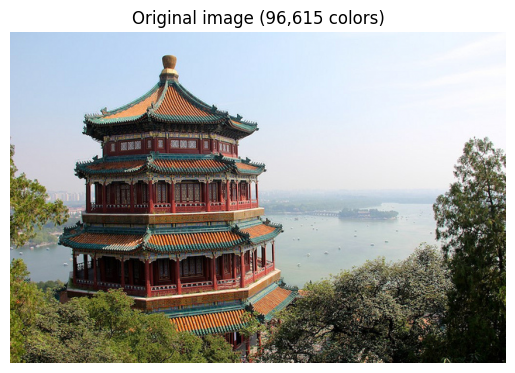

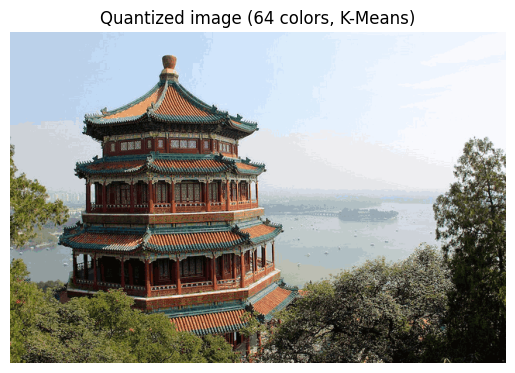

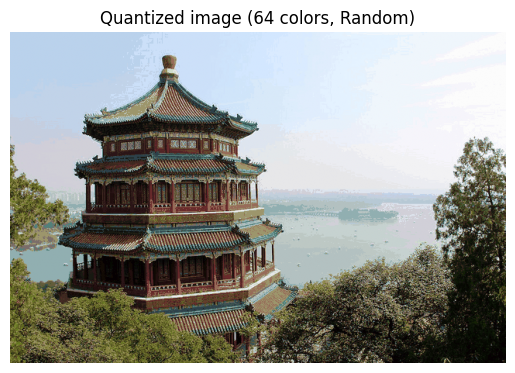

In [7]:
# Display all results, alongside original image
plt.figure(1)
plt.clf()
plt.axis("off")
plt.title("Original image (96,615 colors)")
plt.imshow(china)

plt.figure(2)
plt.clf()
plt.axis("off")
plt.title(f"Quantized image ({n_colors} colors, K-Means)")
plt.imshow(recreate_image(kmeans.cluster_centers_, labels, w, h))

plt.figure(3)
plt.clf()
plt.axis("off")
plt.title(f"Quantized image ({n_colors} colors, Random)")
plt.imshow(recreate_image(codebook_random, labels_random, w, h))
plt.show()



# Comparison of the K-Means and MiniBatchKMeans clustering algorithms

We want to compare the performance of the MiniBatchKMeans and KMeans: the MiniBatchKMeans is faster, but gives slightly different results (see Mini Batch K-Means).

We will cluster a set of data, first with KMeans and then with MiniBatchKMeans, and plot the results. We will also plot the points that are labelled differently between the two algorithms.

In [8]:
import numpy as np

from sklearn.datasets import make_blobs

np.random.seed(0)

batch_size = 45
centers = [[1, 1], [-1, -1], [1, -1]]
n_clusters = len(centers)
X, labels_true = make_blobs(n_samples=3000, centers=centers, cluster_std=0.7)

In [9]:
import time

from sklearn.cluster import KMeans

k_means = KMeans(init="k-means++", n_clusters=3, n_init=10)
t0 = time.time()
k_means.fit(X)
t_batch = time.time() - t0

In [10]:
from sklearn.cluster import MiniBatchKMeans

mbk = MiniBatchKMeans(
    init="k-means++",
    n_clusters=3,
    batch_size=batch_size,
    n_init=10,
    max_no_improvement=10,
    verbose=0,
)
t0 = time.time()
mbk.fit(X)
t_mini_batch = time.time() - t0

Establishing parity between clusters

We want to have the same color for the same cluster from both the MiniBatchKMeans and the KMeans algorithm. Let’s pair the cluster centers per closest one.

In [12]:
from sklearn.metrics.pairwise import pairwise_distances_argmin

k_means_cluster_centers = k_means.cluster_centers_
order = pairwise_distances_argmin(k_means.cluster_centers_, mbk.cluster_centers_)
mbk_means_cluster_centers = mbk.cluster_centers_[order]

k_means_labels = pairwise_distances_argmin(X, k_means_cluster_centers)
mbk_means_labels = pairwise_distances_argmin(X, mbk_means_cluster_centers)


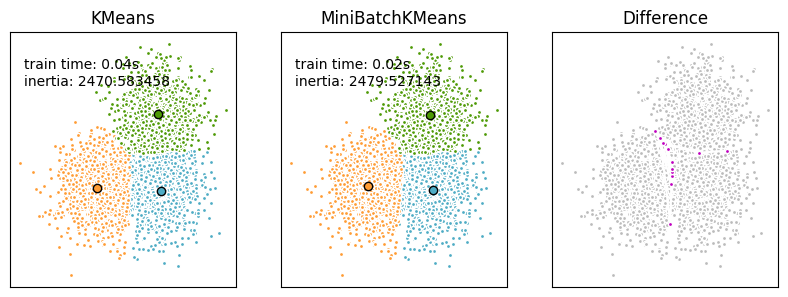

In [13]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 3))
fig.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.9)
colors = ["#4EACC5", "#FF9C34", "#4E9A06"]

# KMeans
ax = fig.add_subplot(1, 3, 1)
for k, col in zip(range(n_clusters), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    ax.plot(X[my_members, 0], X[my_members, 1], "w", markerfacecolor=col, marker=".")
    ax.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=6,
    )
ax.set_title("KMeans")
ax.set_xticks(())
ax.set_yticks(())
plt.text(-3.5, 1.8, "train time: %.2fs\ninertia: %f" % (t_batch, k_means.inertia_))

# MiniBatchKMeans
ax = fig.add_subplot(1, 3, 2)
for k, col in zip(range(n_clusters), colors):
    my_members = mbk_means_labels == k
    cluster_center = mbk_means_cluster_centers[k]
    ax.plot(X[my_members, 0], X[my_members, 1], "w", markerfacecolor=col, marker=".")
    ax.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=6,
    )
ax.set_title("MiniBatchKMeans")
ax.set_xticks(())
ax.set_yticks(())
plt.text(-3.5, 1.8, "train time: %.2fs\ninertia: %f" % (t_mini_batch, mbk.inertia_))

# Initialize the different array to all False
different = mbk_means_labels == 4
ax = fig.add_subplot(1, 3, 3)

for k in range(n_clusters):
    different += (k_means_labels == k) != (mbk_means_labels == k)

identical = np.logical_not(different)
ax.plot(X[identical, 0], X[identical, 1], "w", markerfacecolor="#bbbbbb", marker=".")
ax.plot(X[different, 0], X[different, 1], "w", markerfacecolor="m", marker=".")
ax.set_title("Difference")
ax.set_xticks(())
ax.set_yticks(())

plt.show()

# Demonstration of k-means assumptions

This example is meant to illustrate situations where k-means produces unintuitive and possibly undesirable clusters.

In [1]:
import numpy as np

from sklearn.datasets import make_blobs

n_samples = 1500
random_state = 170
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]

X, y = make_blobs(n_samples=n_samples, random_state=random_state)
X_aniso = np.dot(X, transformation)  # Anisotropic blobs
X_varied, y_varied = make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)  # Unequal variance
X_filtered = np.vstack(
    (X[y == 0][:500], X[y == 1][:100], X[y == 2][:10])
)  # Unevenly sized blobs
y_filtered = [0] * 500 + [1] * 100 + [2] * 10

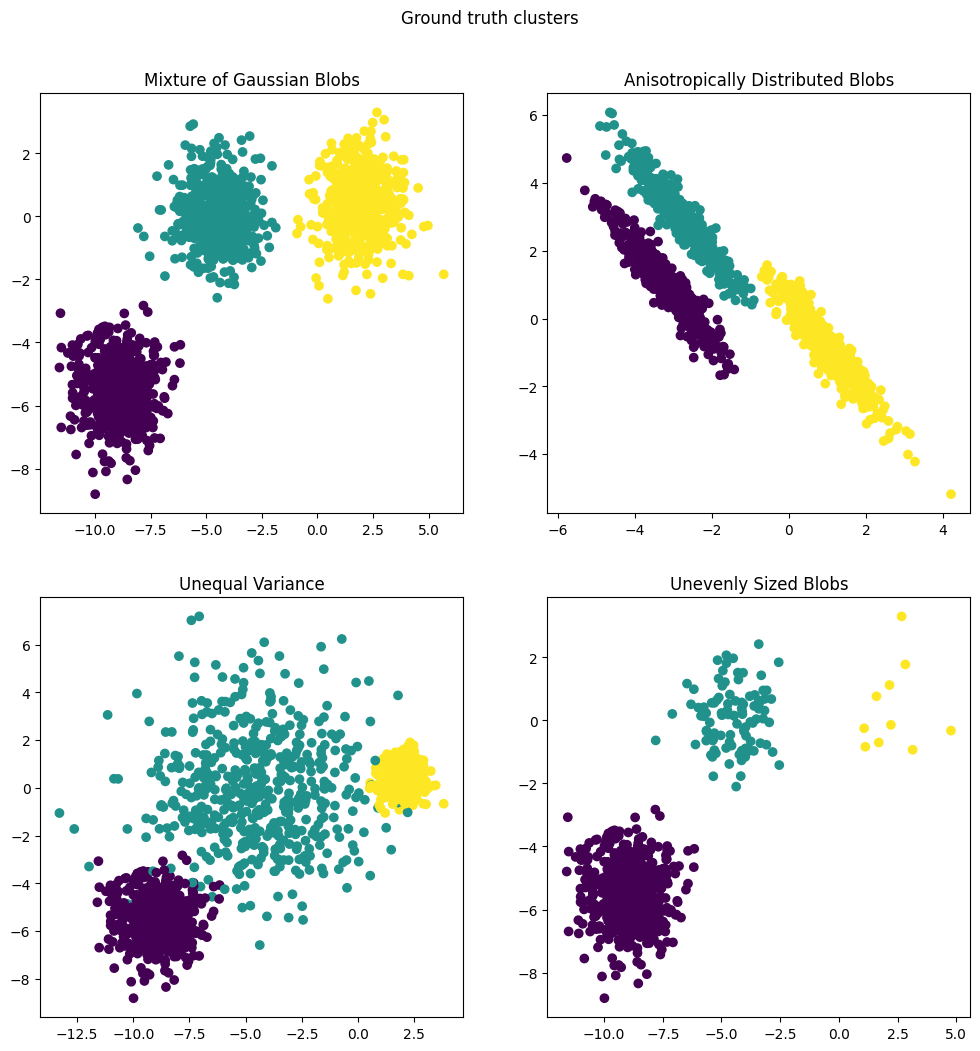

In [2]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

axs[0, 0].scatter(X[:, 0], X[:, 1], c=y)
axs[0, 0].set_title("Mixture of Gaussian Blobs")

axs[0, 1].scatter(X_aniso[:, 0], X_aniso[:, 1], c=y)
axs[0, 1].set_title("Anisotropically Distributed Blobs")

axs[1, 0].scatter(X_varied[:, 0], X_varied[:, 1], c=y_varied)
axs[1, 0].set_title("Unequal Variance")

axs[1, 1].scatter(X_filtered[:, 0], X_filtered[:, 1], c=y_filtered)
axs[1, 1].set_title("Unevenly Sized Blobs")

plt.suptitle("Ground truth clusters").set_y(0.95)
plt.show()

Fit models and plot results

The previously generated data is now used to show how KMeans behaves in the following scenarios:

- Non-optimal number of clusters: in a real setting there is no uniquely defined true number of clusters. An appropriate number of clusters has to be decided from data-based criteria and knowledge of the intended goal.
- Anisotropically distributed blobs: k-means consists of minimizing sample’s euclidean distances to the centroid of the cluster they are assigned to. As a consequence, k-means is more appropriate for clusters that are isotropic and normally distributed (i.e. spherical gaussians).
- Unequal variance: k-means is equivalent to taking the maximum likelihood estimator for a “mixture” of k gaussian distributions with the same variances but with possibly different means.
- Unevenly sized blobs: there is no theoretical result about k-means that states that it requires similar cluster sizes to perform well, yet minimizing euclidean distances does mean that the more sparse and high-dimensional the problem is, the higher is the need to run the algorithm with different centroid seeds to ensure a global minimal inertia.

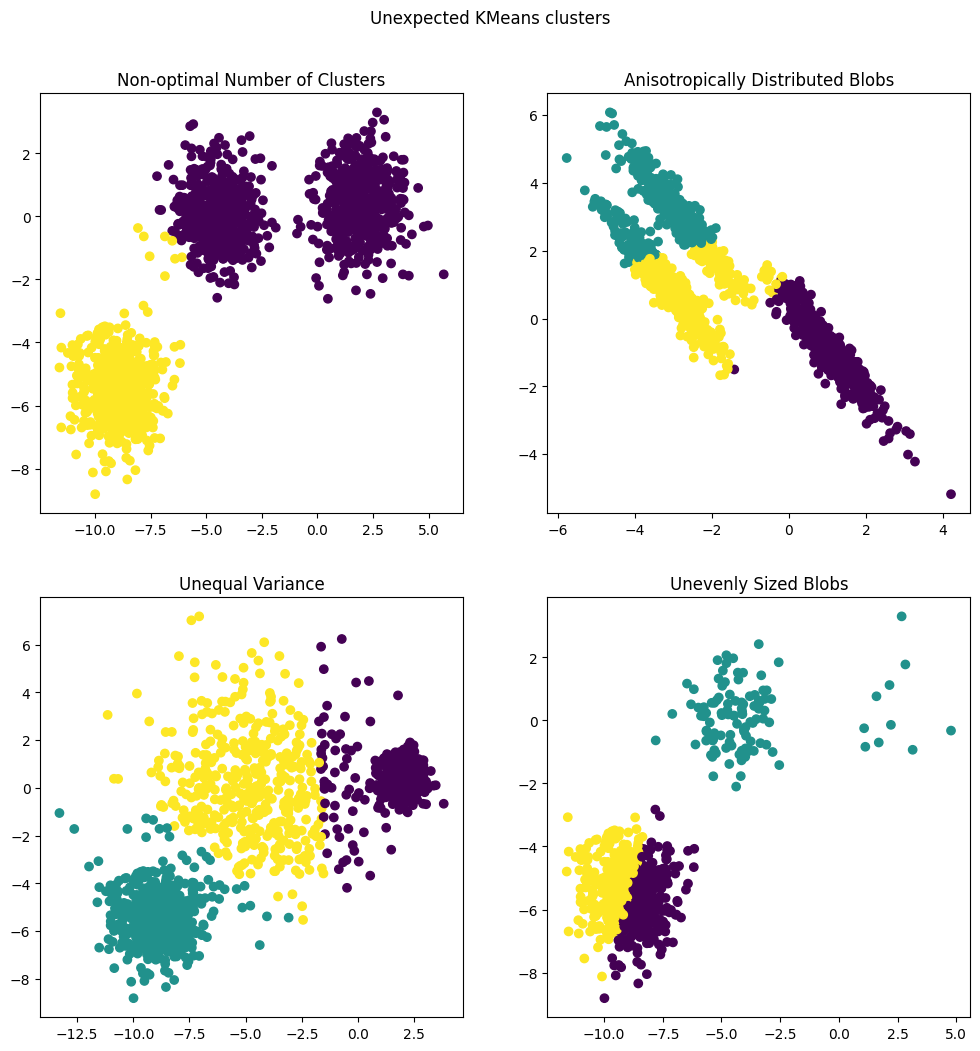

In [3]:
from sklearn.cluster import KMeans

common_params = {
    "n_init": "auto",
    "random_state": random_state,
}

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

y_pred = KMeans(n_clusters=2, **common_params).fit_predict(X)
axs[0, 0].scatter(X[:, 0], X[:, 1], c=y_pred)
axs[0, 0].set_title("Non-optimal Number of Clusters")

y_pred = KMeans(n_clusters=3, **common_params).fit_predict(X_aniso)
axs[0, 1].scatter(X_aniso[:, 0], X_aniso[:, 1], c=y_pred)
axs[0, 1].set_title("Anisotropically Distributed Blobs")

y_pred = KMeans(n_clusters=3, **common_params).fit_predict(X_varied)
axs[1, 0].scatter(X_varied[:, 0], X_varied[:, 1], c=y_pred)
axs[1, 0].set_title("Unequal Variance")

y_pred = KMeans(n_clusters=3, **common_params).fit_predict(X_filtered)
axs[1, 1].scatter(X_filtered[:, 0], X_filtered[:, 1], c=y_pred)
axs[1, 1].set_title("Unevenly Sized Blobs")

plt.suptitle("Unexpected KMeans clusters").set_y(0.95)
plt.show()

Possible solutions

For an example on how to find a correct number of blobs, see Selecting the number of clusters with silhouette analysis on KMeans clustering. In this case it suffices to set n_clusters=3.

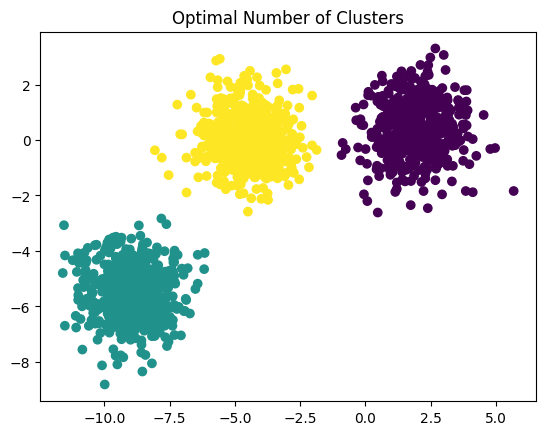

In [4]:
y_pred = KMeans(n_clusters=3, **common_params).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("Optimal Number of Clusters")
plt.show()

To deal with unevenly sized blobs one can increase the number of random initializations. In this case we set n_init=10 to avoid finding a sub-optimal local minimum. For more details see Clustering sparse data with k-means.



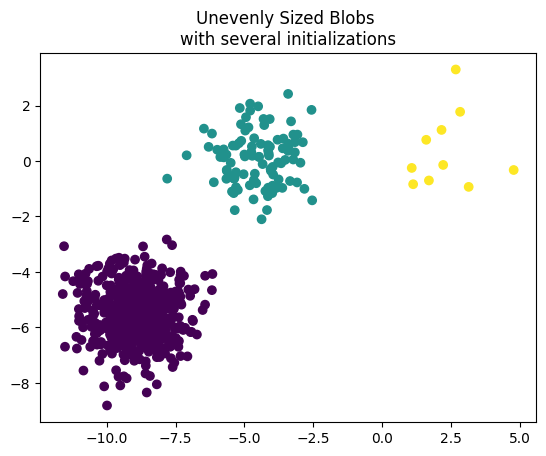

In [5]:
y_pred = KMeans(n_clusters=3, n_init=10, random_state=random_state).fit_predict(
    X_filtered
)
plt.scatter(X_filtered[:, 0], X_filtered[:, 1], c=y_pred)
plt.title("Unevenly Sized Blobs \nwith several initializations")
plt.show()

As anisotropic and unequal variances are real limitations of the k-means algorithm, here we propose instead the use of GaussianMixture, which also assumes gaussian clusters but does not impose any constraints on their variances. Notice that one still has to find the correct number of blobs (see Gaussian Mixture Model Selection).

For an example on how other clustering methods deal with anisotropic or unequal variance blobs, see the example Comparing different clustering algorithms on toy datasets.

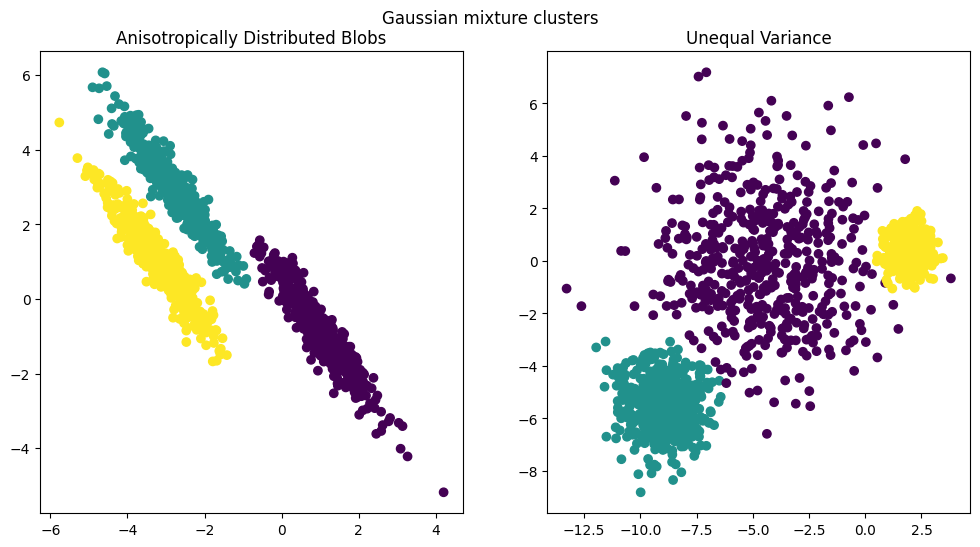

In [6]:
from sklearn.mixture import GaussianMixture

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

y_pred = GaussianMixture(n_components=3).fit_predict(X_aniso)
ax1.scatter(X_aniso[:, 0], X_aniso[:, 1], c=y_pred)
ax1.set_title("Anisotropically Distributed Blobs")

y_pred = GaussianMixture(n_components=3).fit_predict(X_varied)
ax2.scatter(X_varied[:, 0], X_varied[:, 1], c=y_pred)
ax2.set_title("Unequal Variance")

plt.suptitle("Gaussian mixture clusters").set_y(0.95)
plt.show()

Final remarks

In high-dimensional spaces, Euclidean distances tend to become inflated (not shown in this example). Running a dimensionality reduction algorithm prior to k-means clustering can alleviate this problem and speed up the computations (see the example Clustering text documents using k-means).

In the case where clusters are known to be isotropic, have similar variance and are not too sparse, the k-means algorithm is quite effective and is one of the fastest clustering algorithms available. This advantage is lost if one has to restart it several times to avoid convergence to a local minimum.

# Empirical evaluation of the impact of k-means initialization

Evaluate the ability of k-means initializations strategies to make the algorithm convergence robust, as measured by the relative standard deviation of the inertia of the clustering (i.e. the sum of squared distances to the nearest cluster center).

The first plot shows the best inertia reached for each combination of the model (KMeans or MiniBatchKMeans), and the init method (init="random" or init="k-means++") for increasing values of the n_init parameter that controls the number of initializations.

The second plot demonstrates one single run of the MiniBatchKMeans estimator using a init="random" and n_init=1. This run leads to a bad convergence (local optimum), with estimated centers stuck between ground truth clusters.

The dataset used for evaluation is a 2D grid of isotropic Gaussian clusters widely spaced.

Evaluation of KMeans with k-means++ init
Evaluation of KMeans with random init
Evaluation of MiniBatchKMeans with k-means++ init
Evaluation of MiniBatchKMeans with random init


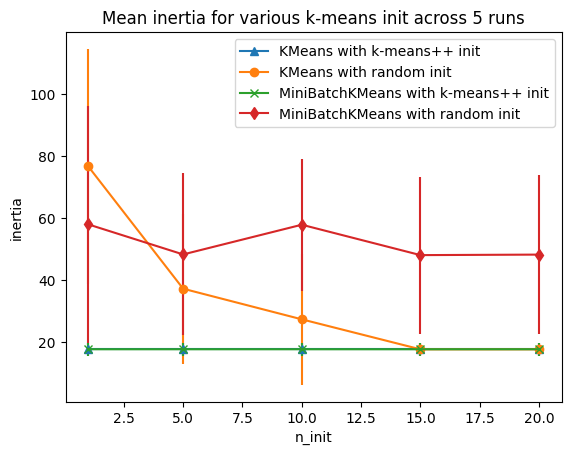

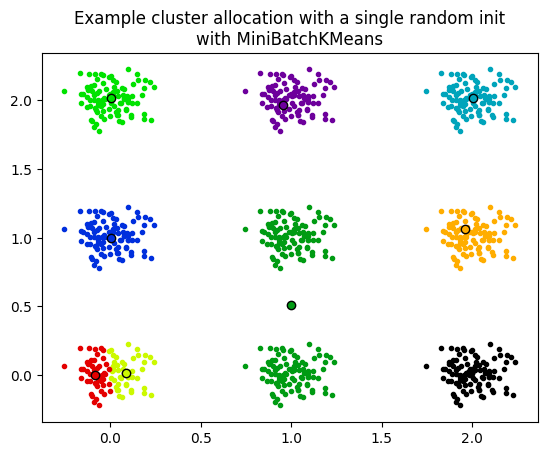

In [11]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.utils import check_random_state, shuffle

random_state = np.random.RandomState(0)

# Number of run (with randomly generated dataset) for each strategy so as
# to be able to compute an estimate of the standard deviation
n_runs = 5

# k-means models can do several random inits so as to be able to trade
# CPU time for convergence robustness
n_init_range = np.array([1, 5, 10, 15, 20])

# Datasets generation parameters
n_samples_per_center = 100
grid_size = 3
scale = 0.1
n_clusters = grid_size**2


def make_data(random_state, n_samples_per_center, grid_size, scale):
    random_state = check_random_state(random_state)
    centers = np.array([[i, j] for i in range(grid_size) for j in range(grid_size)])
    n_clusters_true, n_features = centers.shape

    noise = random_state.normal(
        scale=scale, size=(n_samples_per_center, centers.shape[1])
    )

    X = np.concatenate([c + noise for c in centers])
    y = np.concatenate([[i] * n_samples_per_center for i in range(n_clusters_true)])
    return shuffle(X, y, random_state=random_state)


# Part 1: Quantitative evaluation of various init methods


plt.figure()
plots = []
legends = []

cases = [
    (KMeans, "k-means++", {}, "^-"),
    (KMeans, "random", {}, "o-"),
    (MiniBatchKMeans, "k-means++", {"max_no_improvement": 3}, "x-"),
    (MiniBatchKMeans, "random", {"max_no_improvement": 3, "init_size": 500}, "d-"),
]

for factory, init, params, format in cases:
    print("Evaluation of %s with %s init" % (factory.__name__, init))
    inertia = np.empty((len(n_init_range), n_runs))

    for run_id in range(n_runs):
        X, y = make_data(run_id, n_samples_per_center, grid_size, scale)
        for i, n_init in enumerate(n_init_range):
            km = factory(
                n_clusters=n_clusters,
                init=init,
                random_state=run_id,
                n_init=n_init,
                **params,
            ).fit(X)
            inertia[i, run_id] = km.inertia_
    p = plt.errorbar(
        n_init_range, inertia.mean(axis=1), inertia.std(axis=1), fmt=format
    )
    plots.append(p[0])
    legends.append("%s with %s init" % (factory.__name__, init))

plt.xlabel("n_init")
plt.ylabel("inertia")
plt.legend(plots, legends)
plt.title("Mean inertia for various k-means init across %d runs" % n_runs)

# Part 2: Qualitative visual inspection of the convergence

X, y = make_data(random_state, n_samples_per_center, grid_size, scale)
km = MiniBatchKMeans(
    n_clusters=n_clusters, init="random", n_init=1, random_state=random_state
).fit(X)

plt.figure()
for k in range(n_clusters):
    my_members = km.labels_ == k
    color = cm.nipy_spectral(float(k) / n_clusters, 1)
    plt.plot(X[my_members, 0], X[my_members, 1], ".", c=color)
    cluster_center = km.cluster_centers_[k]
    plt.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=color,
        markeredgecolor="k",
        markersize=6,
    )
    plt.title(
        "Example cluster allocation with a single random init\nwith MiniBatchKMeans"
    )

plt.show()

# Selecting the number of clusters with silhouette analysis on KMeans clustering

Silhouette analysis can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. This measure has a range of [-1, 1].

Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.

In this example the silhouette analysis is used to choose an optimal value for n_clusters. The silhouette plot shows that the n_clusters value of 3, 5 and 6 are a bad pick for the given data due to the presence of clusters with below average silhouette scores and also due to wide fluctuations in the size of the silhouette plots. Silhouette analysis is more ambivalent in deciding between 2 and 4.

Also from the thickness of the silhouette plot the cluster size can be visualized. The silhouette plot for cluster 0 when n_clusters is equal to 2, is bigger in size owing to the grouping of the 3 sub clusters into one big cluster. However when the n_clusters is equal to 4, all the plots are more or less of similar thickness and hence are of similar sizes as can be also verified from the labelled scatter plot on the right.

In [14]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X, y = make_blobs(
    n_samples=500,
    n_features=2,
    centers=4,
    cluster_std=1,
    center_box=(-10.0, 10.0),
    shuffle=True,
    random_state=1,
)  # For reproducibility

range_n_clusters = [2, 3, 4, 5, 6]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 2 The average silhouette_score is : 0.7049787496083262


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 3 The average silhouette_score is : 0.5882004012129721


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 4 The average silhouette_score is : 0.6505186632729437


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 5 The average silhouette_score is : 0.56376469026194


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 6 The average silhouette_score is : 0.4504666294372765


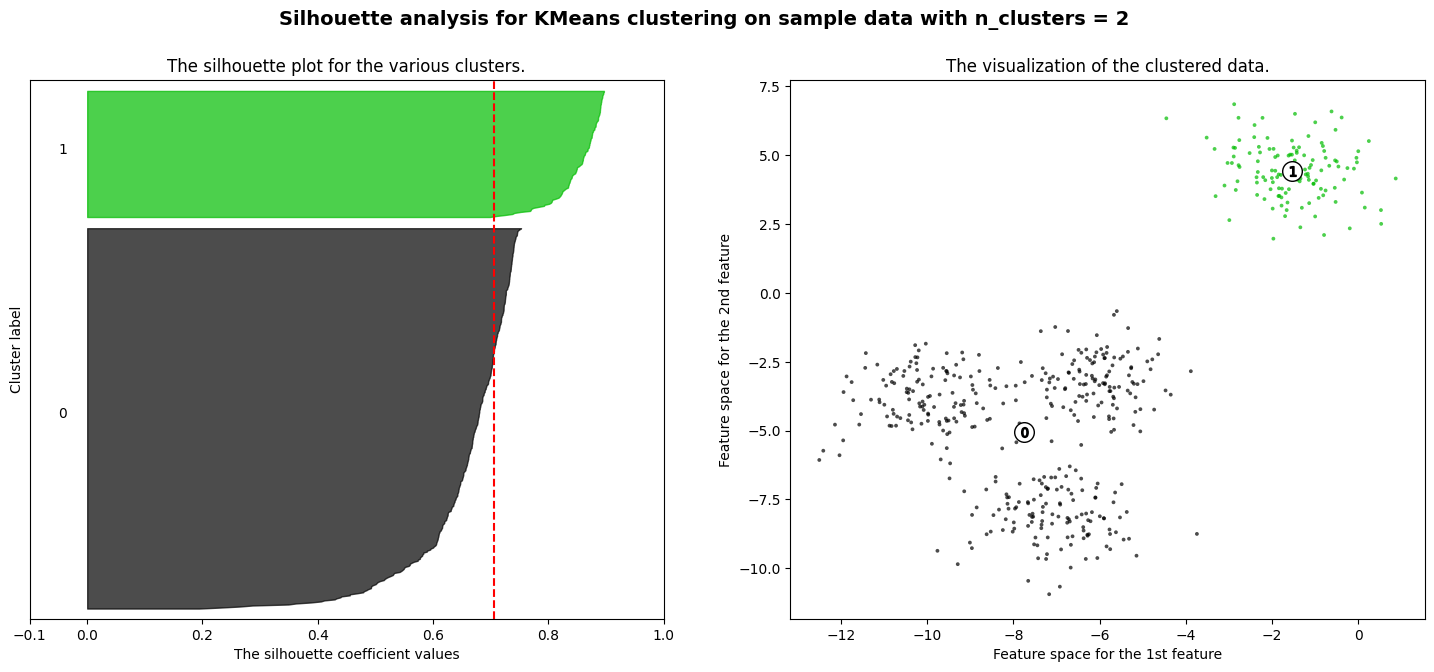

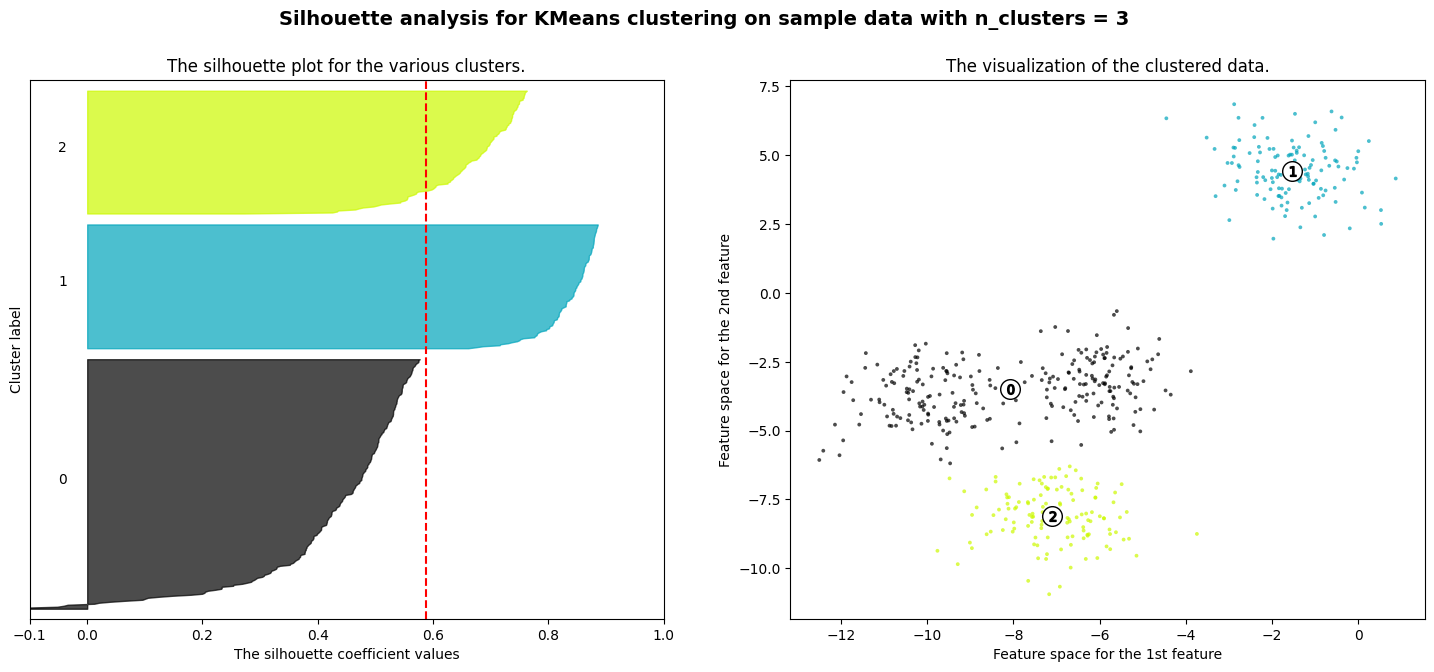

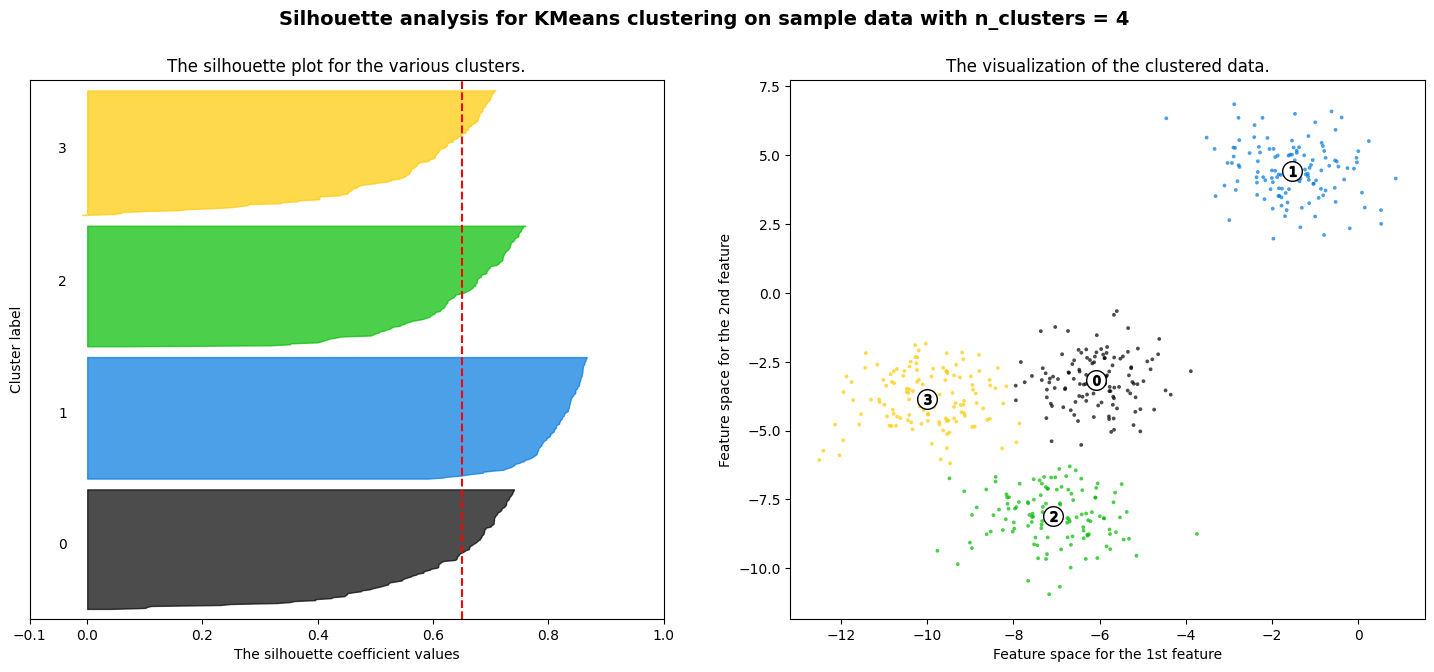

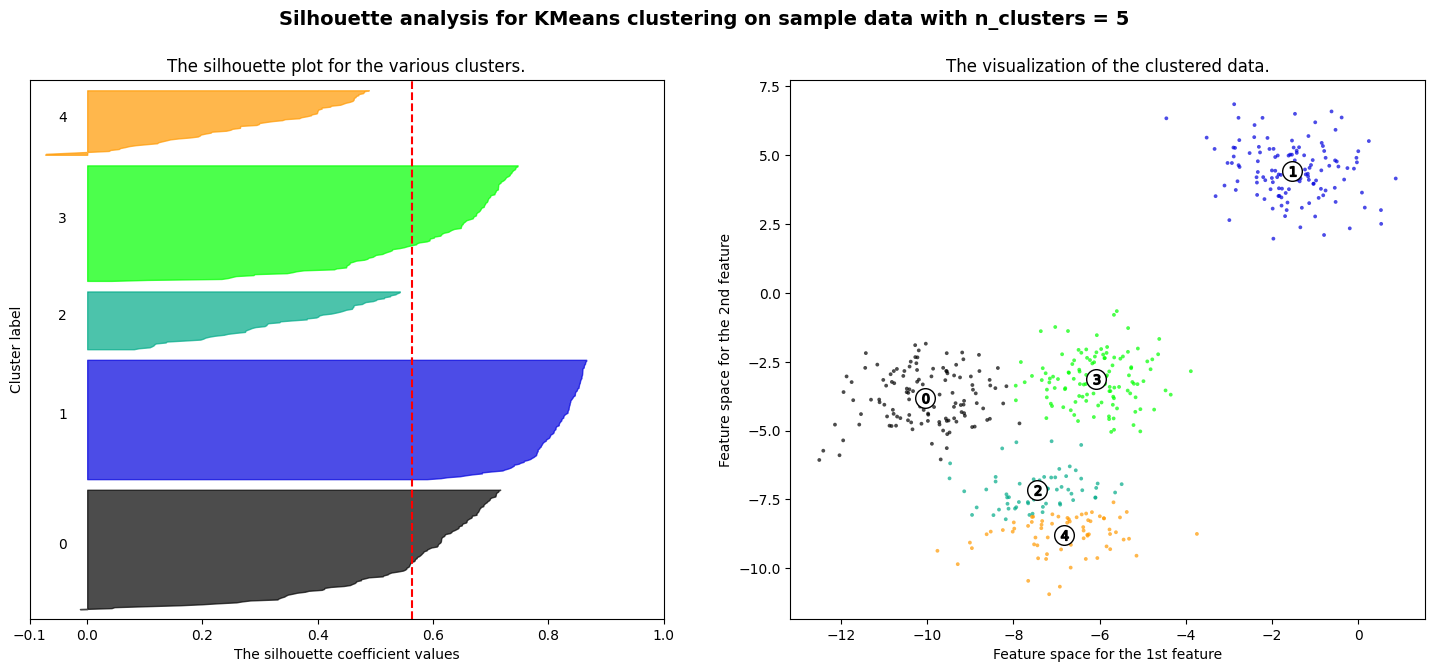

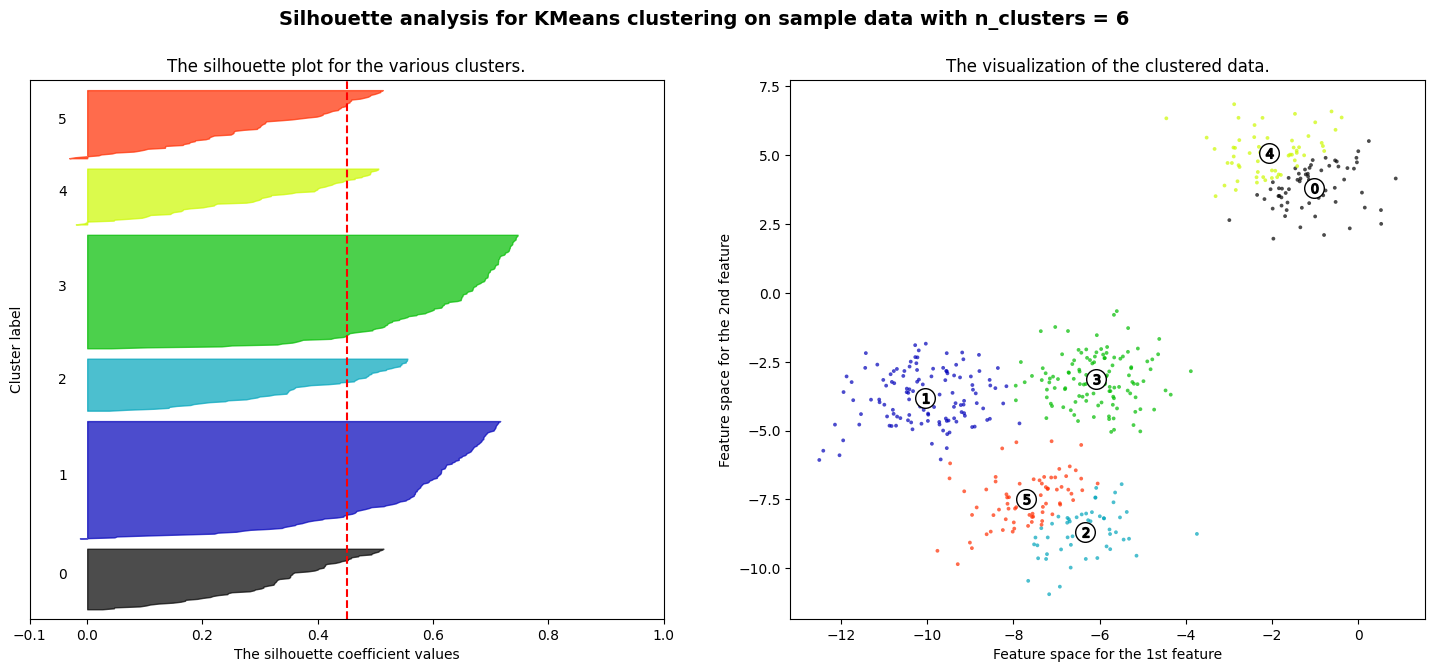

In [15]:
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()